In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

import os
import functools as reduce
from pyspark.context import SparkContext
from pyspark.sql import DataFrame, SQLContext, SparkSession, Window
from pyspark.sql.functions import *
from pyspark.sql.types import *

# Importing other MLlib Libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

conf = pyspark.SparkConf().setAppName('Clustering').setMaster('local')
sc = pyspark.SparkContext(conf = conf)
spark = SparkSession(sc)
sqlContext = SQLContext(sc)

In [2]:
# Importing other relevant libraries
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
spark

In [ ]:
# Dataset Link: https://github.com/JaiAhuja/Datasets/blob/main/Analytics%20Using%20PySpark/music_data.csv

In [4]:
# Reading the dataset
df = spark.read.csv(r"music_data.csv", header=True, inferSchema=True)
df.show(10)

+--------------------+--------------------+--------------------+-----+
|              userid|            artistid|         artist_name|plays|
+--------------------+--------------------+--------------------+-----+
|00000c289a1829a80...|3bd73256-3905-4f3...|     betty blowtorch| 2137|
|00000c289a1829a80...|f2fb0ff0-5679-42e...|           die Ärzte| 1099|
|00000c289a1829a80...|b3ae82c2-e60b-455...|   melissa etheridge|  897|
|00000c289a1829a80...|3d6bbeb7-f90e-4d1...|           elvenking|  717|
|00000c289a1829a80...|bbd2ffd7-17f4-450...|juliette & the licks|  706|
|00000c289a1829a80...|8bfac288-ccc5-448...|red hot chili pep...|  691|
|00000c289a1829a80...|6531c8b1-76ea-414...|              magica|  545|
|00000c289a1829a80...|21f3573f-10cf-44b...|the black dahlia ...|  507|
|00000c289a1829a80...|c5db90c4-580d-4f3...|         the murmurs|  424|
|00000c289a1829a80...|0639533a-0402-40b...|          lunachicks|  403|
+--------------------+--------------------+--------------------+-----+
only s

In [5]:
# Checking the count
df.count()

999

In [6]:
# Selecting only artist since, we want artist clusters
df_artist = df.select(["artist_name", "plays"])
df_artist.show()

+--------------------+-----+
|         artist_name|plays|
+--------------------+-----+
|     betty blowtorch| 2137|
|           die Ärzte| 1099|
|   melissa etheridge|  897|
|           elvenking|  717|
|juliette & the licks|  706|
|red hot chili pep...|  691|
|              magica|  545|
|the black dahlia ...|  507|
|         the murmurs|  424|
|          lunachicks|  403|
|    walls of jericho|  393|
|      letzte instanz|  387|
|           goldfrapp|  361|
|          horrorpops|  358|
|        the butchies|  329|
|       jack off jill|  316|
|    babes in toyland|  310|
|    dropkick murphys|  302|
|       all:my:faults|  288|
|            le tigre|  281|
+--------------------+-----+
only showing top 20 rows



In [7]:
# Since, there can be multiple users listening to the same artist. Hence, grouping
artist_aggr = df_artist.groupby("artist_name").sum()
artist_aggr.show(10)

+----------------+----------+
|     artist_name|sum(plays)|
+----------------+----------+
|        le tigre|       281|
|              l7|       135|
|             fog|       132|
|           hanna|         4|
| raymond & maria|       737|
|       amplifier|       175|
|     the beatles|      1041|
|      television|         7|
|    steel attack|       551|
|john jacob niles|        57|
+----------------+----------+
only showing top 10 rows



In [8]:
# Checking the count after aggregating
df.count()

999

In [9]:
artist_aggr.columns

['artist_name', 'sum(plays)']

In [10]:
artist_aggr.select("sum(plays)").show()

+----------+
|sum(plays)|
+----------+
|       281|
|       135|
|       132|
|         4|
|       737|
|       175|
|      1041|
|         7|
|       551|
|        57|
|        95|
|        32|
|       200|
|       254|
|       313|
|       199|
|        49|
|        16|
|       171|
|        93|
+----------+
only showing top 20 rows



In [11]:
# Renaming the column
artist_data = artist_aggr.withColumnRenamed("sum(plays)", "plays_sum")

In [12]:
artist_data.show(10)

+----------------+---------+
|     artist_name|plays_sum|
+----------------+---------+
|        le tigre|      281|
|              l7|      135|
|             fog|      132|
|           hanna|        4|
| raymond & maria|      737|
|       amplifier|      175|
|     the beatles|     1041|
|      television|        7|
|    steel attack|      551|
|john jacob niles|       57|
+----------------+---------+
only showing top 10 rows



In [13]:
# VectorAssembler
assembler = VectorAssembler(inputCols=["plays_sum"], outputCol="features")

In [14]:
# Transforming the data
model_data = assembler.transform(artist_data)
model_data.show(10)

+----------------+---------+--------+
|     artist_name|plays_sum|features|
+----------------+---------+--------+
|        le tigre|      281| [281.0]|
|              l7|      135| [135.0]|
|             fog|      132| [132.0]|
|           hanna|        4|   [4.0]|
| raymond & maria|      737| [737.0]|
|       amplifier|      175| [175.0]|
|     the beatles|     1041|[1041.0]|
|      television|        7|   [7.0]|
|    steel attack|      551| [551.0]|
|john jacob niles|       57|  [57.0]|
+----------------+---------+--------+
only showing top 10 rows



### Model Building

#### KMeans Clustering

In [15]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [16]:
kmeans = KMeans(k= 7, seed= 2)

In [17]:
model = kmeans.fit(model_data.select("features"))

In [18]:
# Make predictions
output = model.transform(model_data)

In [19]:
output.show(10)

+----------------+---------+--------+----------+
|     artist_name|plays_sum|features|prediction|
+----------------+---------+--------+----------+
|        le tigre|      281| [281.0]|         0|
|              l7|      135| [135.0]|         0|
|             fog|      132| [132.0]|         0|
|           hanna|        4|   [4.0]|         0|
| raymond & maria|      737| [737.0]|         4|
|       amplifier|      175| [175.0]|         0|
|     the beatles|     1041|[1041.0]|         6|
|      television|        7|   [7.0]|         0|
|    steel attack|      551| [551.0]|         4|
|john jacob niles|       57|  [57.0]|         0|
+----------------+---------+--------+----------+
only showing top 10 rows



In [20]:
# Creating Temp View for SQL Queries
output.createOrReplaceTempView("output_view")

In [21]:
spark.sql("""
select artist_name, prediction
from output_view
order by plays_sum desc
""").show(100)

+--------------------+----------+
|         artist_name|prediction|
+--------------------+----------+
|the most serene r...|         1|
|     nine inch nails|         1|
|               stars|         2|
| broken social scene|         2|
|          have heart|         2|
|         bright eyes|         2|
|      arctic monkeys|         2|
|     luminous orange|         2|
|               boris|         2|
|coaltar of the de...|         5|
|     polar bear club|         5|
|      the libertines|         5|
|           blink-182|         5|
|            coldplay|         5|
|death from above ...|         5|
|            owl city|         5|
|           radiohead|         3|
|      okkervil river|         3|
|        jim sturgess|         3|
|david & the citizens|         3|
|            deerhoof|         3|
|fear before the m...|         3|
|    breathe carolina|         3|
|         arcade fire|         3|
|     betty blowtorch|         3|
|            mstrkrft|         3|
|        judas

In [22]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

In [23]:
silhouette = evaluator.evaluate(output)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.842623341681741
Cluster Centers: 
[93.67993367]
[11927.5]
[5832.14285714]
[2157.11111111]
[517.96531792]
[3760.14285714]
[1204.91489362]


In [24]:
model_data.show()

+----------------+---------+--------+
|     artist_name|plays_sum|features|
+----------------+---------+--------+
|        le tigre|      281| [281.0]|
|              l7|      135| [135.0]|
|             fog|      132| [132.0]|
|           hanna|        4|   [4.0]|
| raymond & maria|      737| [737.0]|
|       amplifier|      175| [175.0]|
|     the beatles|     1041|[1041.0]|
|      television|        7|   [7.0]|
|    steel attack|      551| [551.0]|
|john jacob niles|       57|  [57.0]|
|     teräsbetoni|       95|  [95.0]|
|       lil wayne|       32|  [32.0]|
|  gnarls barkley|      200| [200.0]|
| pedro abrunhosa|      254| [254.0]|
|      hoobastank|      313| [313.0]|
|       goon moon|      199| [199.0]|
|    sweet coffee|       49|  [49.0]|
|         erasure|       16|  [16.0]|
|             mew|      171| [171.0]|
|     dragonforce|       93|  [93.0]|
+----------------+---------+--------+
only showing top 20 rows



In [25]:
# Applying Elbow Method to check if we have optimum number of clusters

silhouette_score = []

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="features", 
                                metricName="silhouette", distanceMeasure="squaredEuclidean")

for k_num in range(3,11):
    print("K:" + str(k_num))
    
    KMeans_algo= KMeans(featuresCol="features", k= k_num, seed= 1)
    
    KMeans_fit= KMeans_algo.fit(model_data)
    
    output = KMeans_fit.transform(model_data)
    
    # Score
    score = evaluator.evaluate(output)
    
    silhouette_score.append(score)
    
    print("Silhouette Score: "+str(score))

K:3
Silhouette Score: 0.956938295694209
K:4
Silhouette Score: 0.8825556388054627
K:5
Silhouette Score: 0.8483297565283625
K:6
Silhouette Score: 0.8295508175760632
K:7
Silhouette Score: 0.8448509767195076
K:8
Silhouette Score: 0.7958240826739195
K:9
Silhouette Score: 0.7611521210900387
K:10
Silhouette Score: 0.8022474502291955


Text(0, 0.5, 'cost')

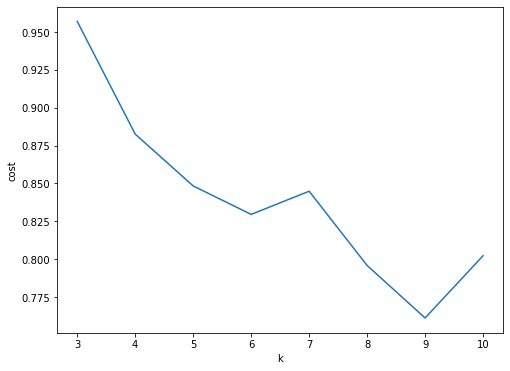

In [27]:
#Visualizing the silhouette scores in a plot
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(3,11),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")